# InceptionNet with CIFAR10

Using inception net as the base model for learning cifar-10 dataset.

## The Dataset

Here I have used the CIFAR-10 dataset which is basically a set of 6 `pickle` files, the first 5 pickle files containing 1000 32x32 RGB images each and the last containing images for testing. To read these images we need load the pickle file, parse it and store the parsed data which we have to later pass to the model for training and validation.

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset_path = '../dataset/cifar-10-batches-py/'

These are the labels which are stored in forms of indices in the pickle file. We dont need the labels until we want to visualize the images and the labels ourselves.

In [3]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'dear', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def read_batch(batch_path):
    with open(batch_path, 'rb') as batch:
        batch_data = pickle.load(batch, encoding='bytes')
    return batch_data

In [5]:
batch_1 = os.path.join(dataset_path, 'data_batch_1')

In [6]:
batch_1_data = read_batch(batch_1)

Each pickle file we read, the data is obtained in form of a dictionary where the value corresponding to the 'data' key is the collection of 1000 32x32 images and the value correspoding to the 'label' key is the 1000 labels associated with each image.

In [7]:
batch_1_data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [8]:
batch_2 = os.path.join(dataset_path, 'data_batch_2')

### Looking at example data

In [9]:
a = np.array(batch_1_data[b'data'][200])

In [10]:
a.shape

(3072,)

In [11]:
a = a.reshape((3, 32, 32))

In [12]:
a = a.transpose([1, 2, 0])

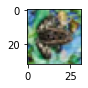

In [13]:
plt.figure(figsize=(1, 1))
plt.imshow(a)

In [14]:
batch_1_data[b'labels'][200]

6

##  Manual Data Manipulation

Here I will manually handle the preprocessing of the data that needs to be given for training the model.

It contains the following steps:
- Extract dictionary from the pickle file
- Extract the images and labels from the dictionary
- Convert the collection of images and dictionary into numpy array for compatibility
- Normalize the images

In [51]:
def convert_to_array(batch_path):
    # this methods normalizes the images
    def preprocess(image):
        image = image/255.0
        return image
    preprocess_vf = np.vectorize(preprocess)
    
    # here we read the pickle file and extract the images and labels
    # we also convert them into numpy array format
    # later we use the preprocess method to normalize the images
    with open(batch_path, 'rb') as batch:
        batch_data = pickle.load(batch, encoding='bytes')
        images = batch_data[b'data']
        images = images.reshape((-1, 3, 32, 32))
        images = images.transpose([0, 3, 2, 1])
        images = preprocess_vf(images)
        labels = np.array(batch_data[b'labels'])
        return images, labels

In [19]:
train_data_x, train_data_y = convert_to_array(batch_1)

In [20]:
train_data_x.shape

(10000, 32, 32, 3)

In [21]:
type(train_data_x)

numpy.ndarray

In [22]:
type(train_data_y)

numpy.ndarray

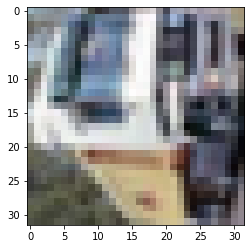

In [23]:
plt.imshow(train_data_x[1])

In [24]:
validation_data_x, validation_data_y = convert_to_array(batch_2)

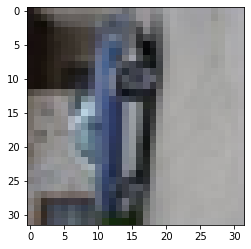

In [25]:
plt.imshow(validation_data_x[0])

## The Pipeline

In [28]:
import tensorflow as tf

In [97]:
batches = tf.data.Dataset.list_files(os.path.join(dataset_path, 'data_batch*'))

In [98]:
for b in batches.take(2):
    print(b.numpy())

b'../dataset/cifar-10-batches-py/data_batch_4'
b'../dataset/cifar-10-batches-py/data_batch_1'


In [99]:
def convert(batch_path):
    with open(batch_path.numpy(), 'rb') as batch:
        batch_data = pickle.load(batch, encoding='bytes')
        images = batch_data[b'data']
        images = images.reshape((-1, 3, 32, 32))
        images = images.transpose([0, 3, 2, 1])
        labels = batch_data[b'labels']
        return images, labels

In [105]:
batches = batches.map(
    lambda file_path: tf.py_function(convert, [file_path], Tout=(tf.float32, tf.float32))
)

In [106]:
batches = batches.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices((x, y)))

In [107]:
def preprocess(image, label):
    image = (image - tf.reduce_mean(image))/255.0
    return image, label

In [108]:
batches = batches.map(preprocess)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


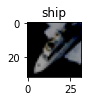

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


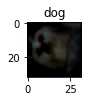

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


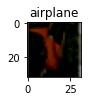

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


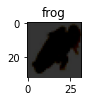

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


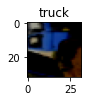

In [109]:
for t in batches.take(5):
    plt.figure(figsize=(1,1))
    plt.imshow(t[0].numpy())
    plt.title(labels[int(t[1].numpy())])
    plt.show()

In [110]:
train_ds = batches.take(1000).batch(32).shuffle(100)
validation_ds = batches.skip(1000).take(100).batch(32)

## The Model

Here I am using a pretrained InceptionNet which has been trained on 'imagenet' dataset. I wont be using the final FCN layers of the inception net because they are trained to fit the 'imagenet' dataset. In place of that I will add my own dense layers so as to fit CIFAR-10 dataset. I will freeze the CNN layers of the network so that they are not trained when fitting the model for CIFAR-10.

**Note: The model cannot take any input less than 75x75 in shape. So we need to resize the images from 32x32 to 75x75**

The steps for using pre-trained inception net for transfer learning are:
- Get the pre-trained InceptionNet model
- Add the image resize layer as the input layer(this could have been done in pre-processing steps but it is done here to take advantage of the GPU)
- Add the dense layers at the end of the InceptionNet
- Compile the model with the required loss function, optimizer and the metrics to monitor
- Fit the model with the data

In [48]:
def get_modified_inception_net():
    inception_net = tf.keras.applications.inception_v3.InceptionV3(
        input_shape=(75, 75, 3),
        include_top=False,
        weights='imagenet'
    )
    for layer in inception_net.layers:
        layer.trainable = False
    my_inception_net_model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(75, 75),
        inception_net,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    my_inception_net_model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return my_inception_net_model

In [60]:
my_inception_net_model = get_modified_inception_net()

### Callbacks

I will be using certain callbacks for better resource utilization
- Early stopping when Validation aaccuracy has stopped improving
- Early stopping when Training accuracy has stopped improving

In [61]:
validation_accuracy_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
)
training_accuracy_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=3,
)

In [62]:
history = my_inception_net_model.fit(
    train_data_x,
    train_data_y,
    batch_size=32,
    validation_data=(validation_data_x[:100], validation_data_y[:100]),
    epochs=100,
    callbacks=[validation_accuracy_callback, training_accuracy_callback]
)

Epoch 1/100
313/313 [==============================] - 19s 47ms/step - loss: 1.8173 - accuracy: 0.3787 - val_loss: 1.3187 - val_accuracy: 0.4800
Epoch 2/100
313/313 [==============================] - 14s 45ms/step - loss: 1.0927 - accuracy: 0.6307 - val_loss: 1.2865 - val_accuracy: 0.5600
Epoch 3/100
313/313 [==============================] - 14s 44ms/step - loss: 0.7849 - accuracy: 0.7404 - val_loss: 1.3116 - val_accuracy: 0.5500
Epoch 4/100
313/313 [==============================] - 13s 43ms/step - loss: 0.4786 - accuracy: 0.8576 - val_loss: 1.3754 - val_accuracy: 0.5700
Epoch 5/100
313/313 [==============================] - 14s 45ms/step - loss: 0.2423 - accuracy: 0.9463 - val_loss: 1.5860 - val_accuracy: 0.5600
Epoch 6/100
313/313 [==============================] - 13s 43ms/step - loss: 0.1049 - accuracy: 0.9835 - val_loss: 1.6431 - val_accuracy: 0.5700
Epoch 7/100
313/313 [==============================] - 14s 44ms/step - loss: 0.0367 - accuracy: 0.9996 - val_loss: 1.7251 - val_ac

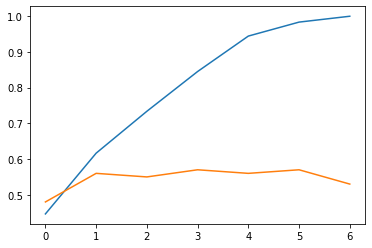

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

## Recording the Result

Here I am dumping the history data for future references

In [75]:
import json
with open('01_simple.json', 'w') as f:
    json.dump(history.history, f)

In [144]:
my_inception_net_model.fit(train_ds, validation_data=validation_ds, steps_per_epoch=32, epochs=5, validation_steps=4)

Epoch 1/5


ValueError: in user code:

    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:370 call
        self._build_graph_network_for_inferred_shape(inputs.shape, inputs.dtype)
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/training/tracking/base.py:517 _method_wrapper
        result = method(self, *args, **kwargs)
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:276 _build_graph_network_for_inferred_shape
        input_shape = tuple(input_shape)
    /home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.3/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:861 __iter__
        raise ValueError("Cannot iterate over a shape with unknown rank.")

    ValueError: Cannot iterate over a shape with unknown rank.
